In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import hvplot.xarray
import hvplot
import cmocean

import matplotlib as mpl

hvplot.output(widget_location='bottom')

from helpers_mom6.collection_of_experiments import CollectionOfExperiments
from helpers_mom6.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord, gaussian_remesh
from helpers.plot_helpers import *

import warnings
warnings.filterwarnings("ignore")


%load_ext autoreload
%autoreload 3

# Spectra

In [2]:
def read_skill(exp='EXP0', factors=[4,9,12,15], base_path='/scratch/pp2681/mom6/CM26_ML_models/ocean3d/'):
    ds = {}
    for factor in factors:
        data = xr.open_dataset(f'{base_path}/{exp}/skill-test/factor-{factor}.nc', chunks={'zl':1})
        data['zl'] = -data['zl']
        ds[factor] = data
        
    return ds

In [3]:
def backscatter_ratio(transfer, freq_str):
    transfer_noncompensated = transfer / transfer[freq_str]
    transfer_plus = np.maximum(transfer_noncompensated,0.0)
    transfer_minus =  np.minimum(transfer_noncompensated,0.0)
    return -transfer_plus.sum(freq_str) / transfer_minus.sum(freq_str)

In [4]:
def plot_transfer(transfer, freq_str='freq_r_NA', zl=0, color='tab:blue'):
    mean = transfer.mean('time').isel(zl=zl)
    std = transfer.std('time').isel(zl=zl)
    
    mean.plot(xscale='log',color=color,lw=2)
    plt.fill_between(mean[freq_str],mean-std,mean+std,alpha=0.05,color=color, linewidth=0)
    return backscatter_ratio(mean,freq_str)

In [5]:
def plot_transfer_4_regions(exps=[],zl=5,factor=4,labels=[]):
    plt.figure(figsize=(10,8))
    plt.rcParams['font.size']=12

    colors= ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink', 'tab:cyan', 'tab:olive', 'tab:brown', 'gray']
    
    plt.subplot(2,2,1)
    ratio = plot_transfer(exps[0][factor].transfer_NA,'freq_r_NA',color='k',zl=zl)
    for exp, color in zip(exps, colors):
        plot_transfer(exp[factor].transfer_ZB_NA,'freq_r_NA',zl=zl,color=color)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('North Atlantic')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.axvline(x=1/(22.6e+3), color='tab:gray', ls='--')
    plt.xlim([1e-6,2e-4])
    plt.text(1e-5, 0, 'Backscat ratio: %.1f' % float(ratio))

    plt.subplot(2,2,2)
    ratio=plot_transfer(exps[0][factor].transfer_Pacific,'freq_r_Pacific',color='k',zl=zl)
    for exp, color in zip(exps,colors):
        plot_transfer(exp[factor].transfer_ZB_Pacific,'freq_r_Pacific',zl=zl,color=color)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('Pacific')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.axvline(x=1/(28.5e+3), color='tab:gray', ls='--')
    plt.xlim([1e-6,2e-4])
    plt.text(1e-5, 0, 'Backscat ratio: %.1f' % float(ratio))
    
    plt.subplot(2,2,3)
    ratio=plot_transfer(exps[0][factor].transfer_ACC,'freq_r_ACC',color='k',zl=zl)
    for exp,color in zip(exps,colors):
        plot_transfer(exp[factor].transfer_ZB_ACC,'freq_r_ACC',zl=zl,color=color)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('ACC')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.axvline(x=1/(10.5e+3), color='tab:gray',ls='--')
    plt.xlim([1e-6,2e-4])
    plt.text(1e-5, 0, 'Backscat ratio: %.1f' % float(ratio))
        
    plt.subplot(2,2,4)
    ratio=plot_transfer(exps[0][factor].transfer_Equator,'freq_r_Equator',color='k',zl=zl)
    for exp,color in zip(exps,colors):
        plot_transfer(exp[factor].transfer_ZB_Equator,'freq_r_Equator',zl=zl,color=color)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('Equator')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.tight_layout()
    plt.axvline(x=1/(89.9e+3), color='tab:gray',ls='--')
    plt.xlim([1e-6,2e-4])
    plt.text(1e-5, 0, 'Backscat ratio: %.1f' % float(ratio))
    
    plt.plot(np.nan,np.nan,color='k',label='SFS')
    for label, color in zip(labels,colors):
        plt.plot(np.nan,np.nan,color=color,label=label)
    plt.plot(np.nan,np.nan,color='gray',ls='--',label='$1/R_d$')
    plt.legend(bbox_to_anchor=(1,1))
    
    plt.suptitle(f'Coarsegraining factor: {factor}, Depth: %.0f m' % (float(-exp[factor].zl[zl])), y=1.03)

In [6]:
import cmocean
def plot_metric(exp0=None, metric='R2',vmin=0,vmax=1):
    exp = xr.concat([exp0[factor] for factor in [4,9,12,15]], dim='factor')
    exp['factor'] = [4,9,12,15]
    exp[metric].drop_vars(['zl','factor']).plot(x='factor', y='zl',cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, cbar_kwargs={'label':''})
    plt.yticks(np.arange(10),[5, 55, 110, 180,330, 730,1500,2500,3500,4500]);
    plt.ylabel('Depth, m')
    plt.xticks(np.arange(4),[4,9,12,15]);
    if metric == 'R2':
        title_str = '$R^2$'
    elif metric == 'corr':
        title_str = 'Correlation'
    elif metric == 'opt_scaling':
        title_str = 'Optimal scaling'
    
    mean_val = float(exp[metric].mean())
    std_val = float(exp[metric].std())
    plt.title(metric+'\n [mean/std]=[%.3f,%.3f]' % (mean_val,std_val))
    
    plt.xlabel('Coarsegraining factor')
    plt.gca().invert_yaxis()

In [7]:
skill = {}

for key in ['stencil-1-no-radius', 'stencil-3-no-radius', 'stencil-5-no-radius',
            'stencil-1-radius', 'stencil-3-radius', 'stencil-5-radius']:
    skill[key] = read_skill(f'subfilter/FGR3/features_stencil/{key}')

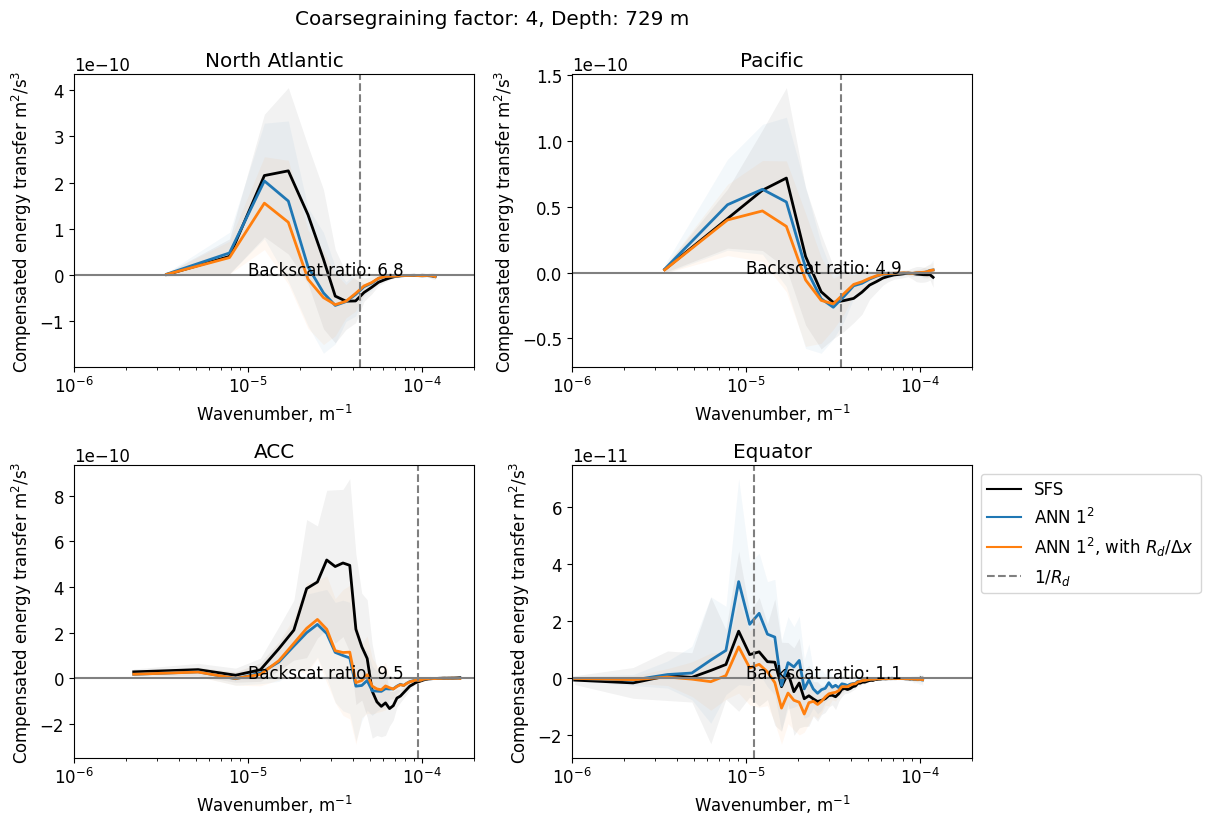

In [79]:
plot_transfer_4_regions(exps=[
                              skill['stencil-1-no-radius'],
                              skill['stencil-1-radius']
                             ], 
                        labels=[
                                'ANN $1^2$',
                                'ANN $1^2$, with $R_d/\Delta x$'
                               ], 
                        factor=4, zl=5)

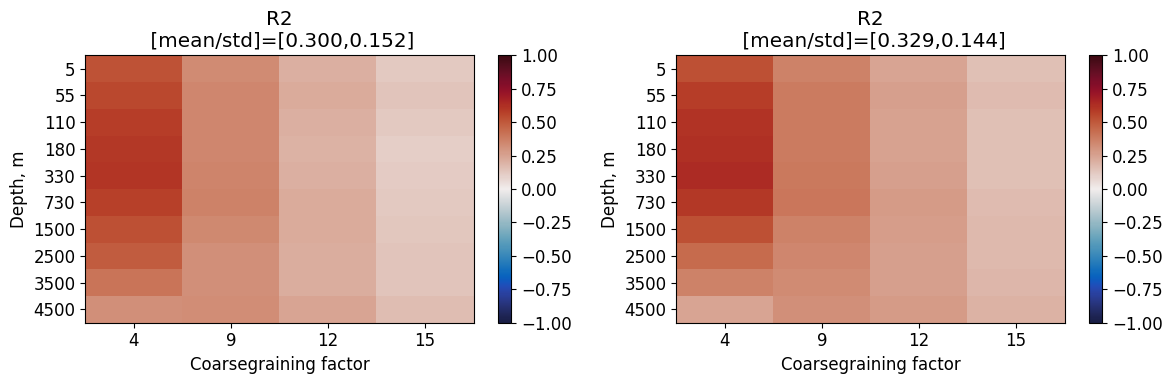

In [29]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_metric(skill['stencil-1-no-radius'], 'R2', vmin=-1); 

plt.subplot(1,2,2)
plot_metric(skill['stencil-1-radius'], 'R2', vmin=-1);
plt.tight_layout()

Correlation: 0.8467787825093935
Relative Error: 0.4309678375720978
R2 =  0.7000800669193268
R2 max =  0.7170360386371613
Optinal scaling: 0.8667187690734863
Nans [test/control]: [0, 0]


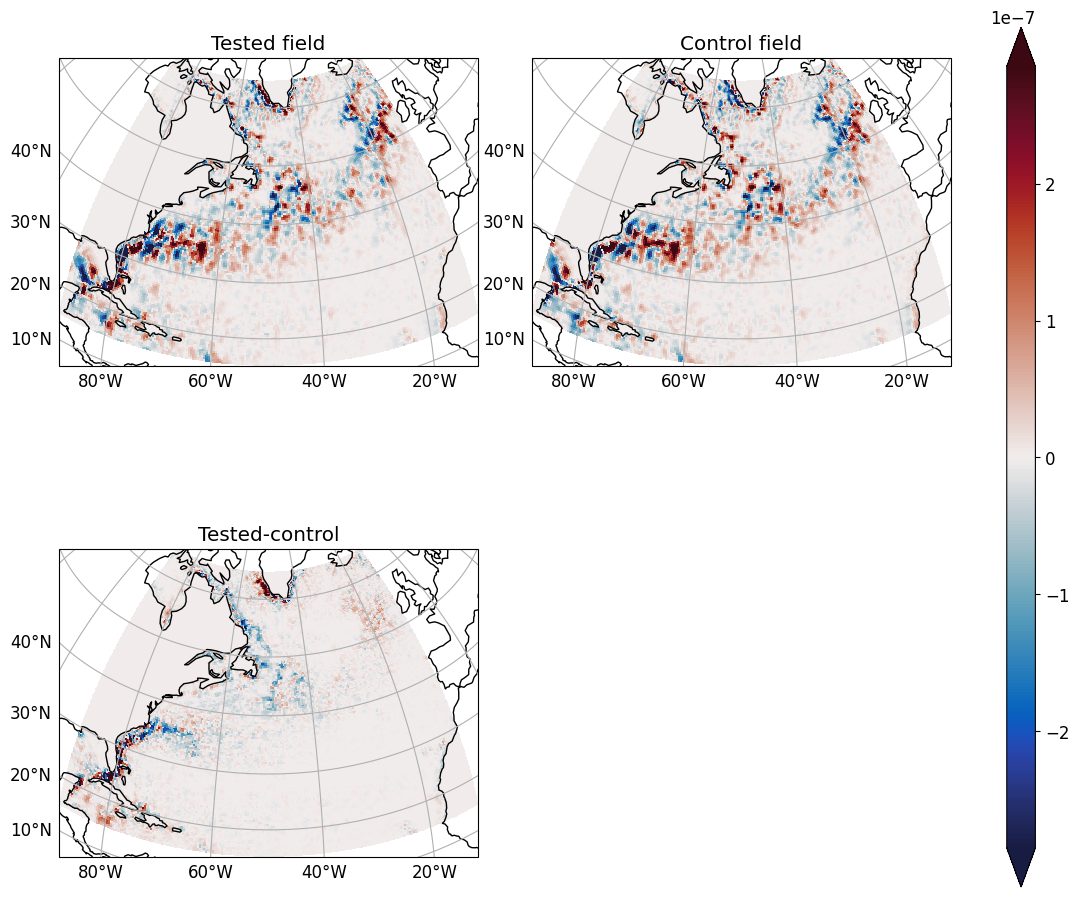

In [35]:
from helpers.selectors import compare
compare(skill['stencil-3-no-radius'][4].ZB20u_mean.isel(zl=0), skill['stencil-3-no-radius'][4].SGSx_mean.isel(zl=0))

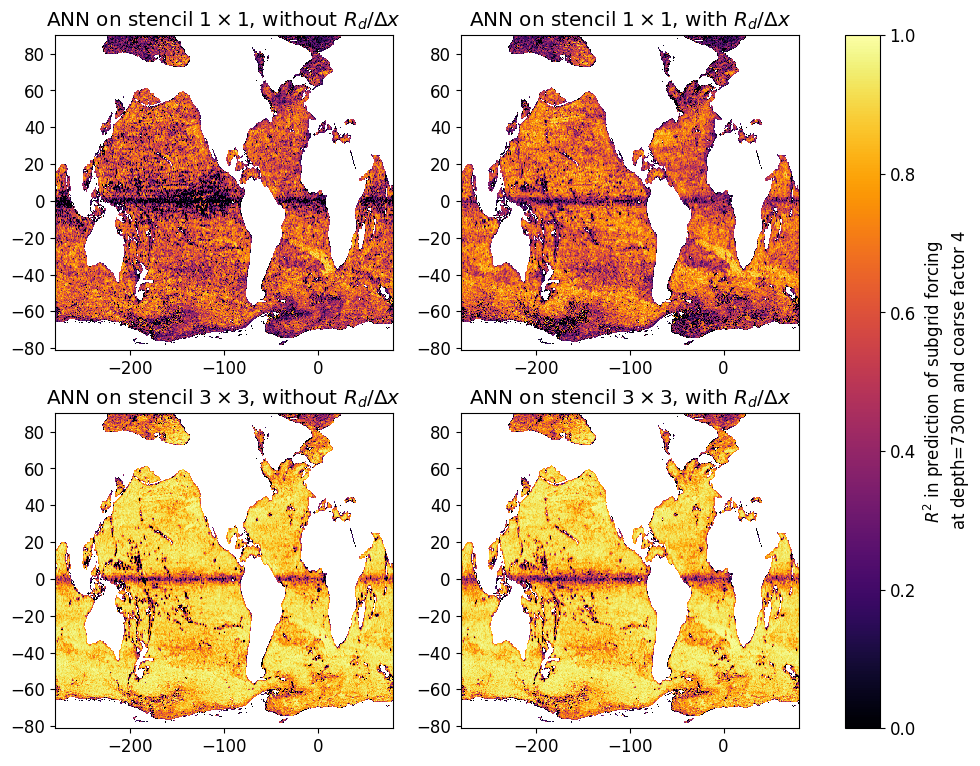

In [114]:
fig, ax = plt.subplots(2,2,figsize=(12,9))
plt.sca(ax[0][0])
skill['stencil-1-no-radius'][4].R2_map.isel(zl=5).plot(vmin=-1e-16, vmax=1, cmap='inferno', add_colorbar=False)
plt.title('ANN on stencil $1\\times1$, without $R_d/\\Delta x$')
plt.xlabel(''); plt.ylabel('')

plt.sca(ax[0][1])
skill['stencil-1-radius'][4].R2_map.isel(zl=5).plot(vmin=-1e-16, vmax=1, cmap='inferno', add_colorbar=False)
plt.title('ANN on stencil $1\\times1$, with $R_d/\\Delta x$')
plt.xlabel(''); plt.ylabel('')

plt.sca(ax[1][0])
skill['stencil-3-no-radius'][4].R2_map.isel(zl=5).plot(vmin=-1e-16, vmax=1, cmap='inferno', add_colorbar=False)
plt.title('ANN on stencil $3\\times3$, without $R_d/\\Delta x$')
plt.xlabel(''); plt.ylabel('')

plt.sca(ax[1][1])
im = skill['stencil-3-radius'][4].R2_map.isel(zl=5).plot(vmin=-1e-16, vmax=1, cmap='inferno', add_colorbar=False)
plt.title('ANN on stencil $3\\times3$, with $R_d/\\Delta x$')
plt.xlabel(''); plt.ylabel('')

plt.colorbar(im, ax=ax.ravel().tolist(),label='$R^2$ in prediction of subgrid forcing\n at depth=730m and coarse factor $4$')

#plt.tight_layout()
plt.savefig('../figures/factor-4.png', dpi=150)

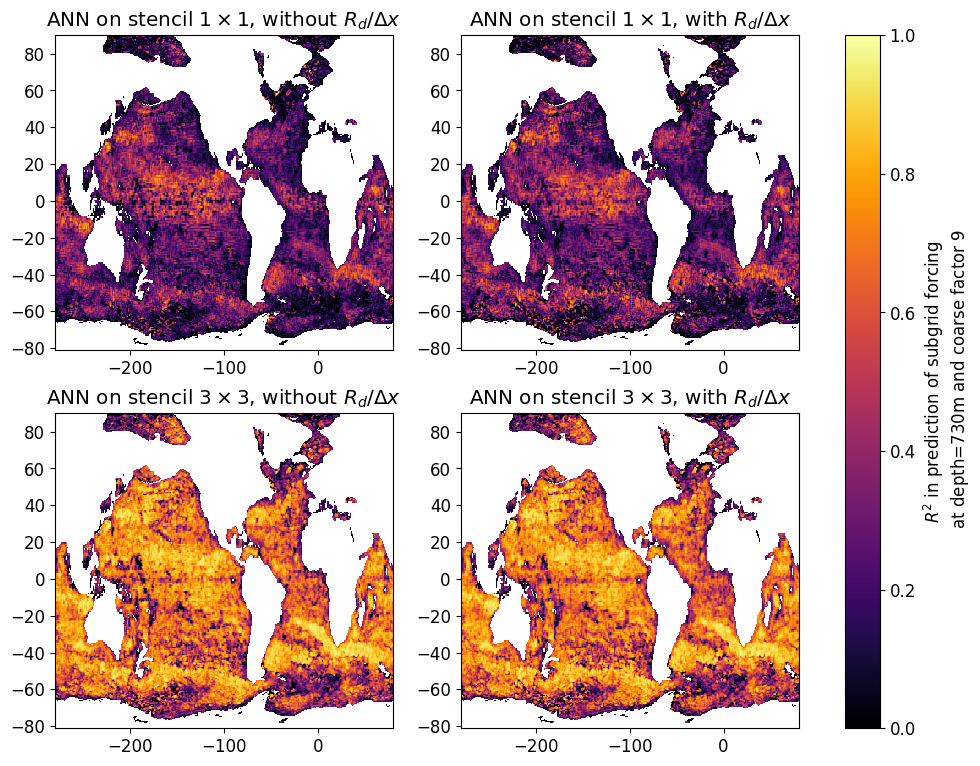

In [116]:
fig, ax = plt.subplots(2,2,figsize=(12,9))
plt.sca(ax[0][0])
skill['stencil-1-no-radius'][9].R2_map.isel(zl=5).plot(vmin=-1e-16, vmax=1, cmap='inferno', add_colorbar=False)
plt.title('ANN on stencil $1\\times1$, without $R_d/\\Delta x$')
plt.xlabel(''); plt.ylabel('')

plt.sca(ax[0][1])
skill['stencil-1-radius'][9].R2_map.isel(zl=5).plot(vmin=-1e-16, vmax=1, cmap='inferno', add_colorbar=False)
plt.title('ANN on stencil $1\\times1$, with $R_d/\\Delta x$')
plt.xlabel(''); plt.ylabel('')

plt.sca(ax[1][0])
skill['stencil-3-no-radius'][9].R2_map.isel(zl=5).plot(vmin=-1e-16, vmax=1, cmap='inferno', add_colorbar=False)
plt.title('ANN on stencil $3\\times3$, without $R_d/\\Delta x$')
plt.xlabel(''); plt.ylabel('')

plt.sca(ax[1][1])
im = skill['stencil-3-radius'][9].R2_map.isel(zl=5).plot(vmin=-1e-16, vmax=1, cmap='inferno', add_colorbar=False)
plt.title('ANN on stencil $3\\times3$, with $R_d/\\Delta x$')
plt.xlabel(''); plt.ylabel('')

plt.colorbar(im, ax=ax.ravel().tolist(),label='$R^2$ in prediction of subgrid forcing\n at depth=730m and coarse factor $9$')

#plt.tight_layout()
plt.savefig('../figures/factor-9.png', dpi=150)